In [199]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StandardScaler, VectorAssembler
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

spark = SparkSession \
        .builder \
        .master('spark://10.10.28.172:7077') \
        .appName('visualizing') \
        .enableHiveSupport() \
        .getOrCreate()

spark.sql('use twitter_data')
spark.sql('show tables').show()


+------------+--------------------+-----------+
|    database|           tableName|isTemporary|
+------------+--------------------+-----------+
|twitter_data|      processed_data|      false|
|twitter_data|            raw_data|      false|
|twitter_data|             results|      false|
|twitter_data|    textblob_results|      false|
|twitter_data|       vader_results|      false|
|twitter_data|wordlist2477_results|      false|
+------------+--------------------+-----------+



22/04/22 23:08:30 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
22/04/22 23:08:30 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


In [200]:
# scaling takes much longer. probably due to the large float numbers
SCALE = True  # if you want to scale the dataframe
COMBINE = True  # if you want to combine all sentiment scores (after grouping)
INTERVAL = '24 hours'

ANALYSERS_TO_PLOT = ['vader_sentiment', 'textblob_sentiment' ,'wordlist2477_sentiment']

query = '''
    SELECT created_at, vader_sentiment, textblob_sentiment, wordlist2477_sentiment
    FROM results
'''

df = spark.sql(query)
df.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- vader_sentiment: float (nullable = true)
 |-- textblob_sentiment: float (nullable = true)
 |-- wordlist2477_sentiment: integer (nullable = true)



## Functions

In [201]:
senti_cols = [col(f'avg({c})') for c in ANALYSERS_TO_PLOT]
average_senti = sum(s_score for s_score in senti_cols)/len(senti_cols)

def plot_events(df, start_date, end_date, interval=INTERVAL, combine=True):
    query = """CAST(created_at AS INT)
            BETWEEN unix_timestamp('{0}', 'yyyy-MM-dd HH:mm:ss')
            AND unix_timestamp('{1}', 'yyyy-MM-dd HH:mm:ss')""".format(start_date,end_date)

    df = df.where(query)

    cols = ['created_at'] + ANALYSERS_TO_PLOT
    results = df. \
        select(cols). \
        groupBy(F.window('created_at', interval)). \
        mean()

    if combine:
        results = results.\
            withColumn('avg_sentiment', average_senti) \
            .select('window', 'avg_sentiment')

    results. \
        withColumn('window', F.col('window').start). \
        sort('window', ascending=True). \
        withColumnRenamed('window', 'interval'). \
        toPandas(). \
        set_index('interval'). \
        plot()

## Scale Sentiment Scores to Make Comparable
The scaling was performed with the standardScaler from pyspark with the following formula:  

μ = mean of variable,  
σ = standard deviation,


x_standarized = (μ - x_i)/σ


In [202]:
# TODO: maybe find another method of scaling

if SCALE:
  print('Performing Scaling')
  sentiment_cols = [x for x, datatype in df.dtypes if datatype != 'timestamp']

  vector_asse = VectorAssembler(inputCols=sentiment_cols, outputCol='sentiment_combined')
  temp_df = vector_asse.transform(df)

  scaler = StandardScaler(inputCol='sentiment_combined', outputCol='scaled_sentiment')
  df = scaler.fit(temp_df).transform(temp_df)

  # Function just to convert to help build data frame
  col_names = ['vader_sentiment','textblob_sentiment','wordlist2477_sentiment','created_at']

  def extract(row):
    return row.scaled_sentiment.toArray().tolist() + [row.created_at]

  scaled_df = df.select(['created_at','scaled_sentiment']).rdd.map(extract).toDF(col_names)
  df = scaled_df

df.show(5)

Performing Scaling


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


+------------------+------------------+----------------------+-------------------+
|   vader_sentiment|textblob_sentiment|wordlist2477_sentiment|         created_at|
+------------------+------------------+----------------------+-------------------+
|1.7617818085853232|2.1711616559562827|    1.9691739611288204|2012-01-01 08:30:42|
|1.7617818085853232|2.1711616559562827|    1.9691739611288204|2012-01-01 08:30:57|
|1.7617818085853232|2.1711616559562827|    1.9691739611288204|2012-01-01 11:11:41|
|1.7617818085853232|2.1711616559562827|    1.9691739611288204|2012-01-01 17:18:58|
|1.7617818085853232|2.1711616559562827|    1.9691739611288204|2012-01-01 19:19:20|
+------------------+------------------+----------------------+-------------------+
only showing top 5 rows



# Whole timeline

In [203]:
start_date = "2012-01-01 00:00:00"
end_date = "2022-04-01 00:00:00"
interval = '4 weeks'

plot_events(df, start_date=start_date, end_date=end_date, interval=interval, combine=COMBINE)

## Major Events in the Ukraine-Russia War

### February 2014


18-23
Revolution of Dignity

Maidan Revolution


22
Annexation of Crimea Begins


27
Crimea parliament captured, russian flag raised



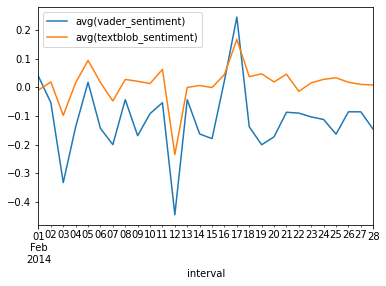

In [ ]:
start_date = "2014-02-01 00:00:00"
end_date = "2014-03-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### March 2014


01
Russian legislature approves use of armed forces


18
Crimea formally annexed


24
Ukraine orders troops to withdraw



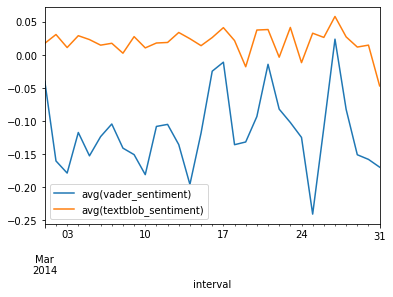

In [ ]:
start_date = "2014-03-01 00:00:00"
end_date = "2014-04-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### April 2014


12
Donbas conflict begins in Donetsk


12
Sloviansk is taken by pro-Russian militants


13
Separatists capture police station in Kramatorsk


13
Counter offensive started by Ukraine


13
Donetsk People's Republic activists took control of the city administration building in Mariupol


14
Militants capture police station in Horlivka


15
Ukraine’s parliament declares Crimea occupied by russia


17
Council deputy member kidnapped


22
Council deputy member body found in river (first reported war crime)


24
Russian forces mobilized 10 km from Ukrainian border



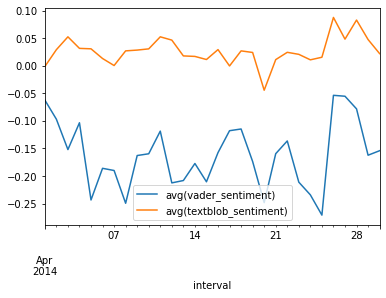

In [ ]:
start_date = "2014-04-01 00:00:00"
end_date = "2014-05-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### May 2014


09
Ukrainian troops launches attack on insurgents in Mariupol (Militants die including a police officer)


No date
A Ukrainian Orthodox church priest attempts to negotiate with separatists, but is later killed with 8 shots.


12
Donbas people’s Militia leader declares himself as Supreme Commander of the Donetsk People’s Republic


15
President of Donetsk People's Republic vows for total annihilation of Ukrainian forces which do not withdraw out of Donbas by 21:00, + declared martial law in Donetsk and Luhansk  


20 
The Donetsk-based steel magnate Rinat Akhmetov called on his 300,000 employees within the Donetsk region to "rally against separatists"


22
A lot of people from both sides ide in fight at checkpoint near the city of Volnovakha


22
The Russia Party established - New Russia state created consisting of Donetsk and Luhansk


26
Donetsk airport battle


30
Ukrainian government forces had "completely cleared" the insurgents from the southern and western parts of Donetsk Oblast and the northern part of Luhansk Oblast



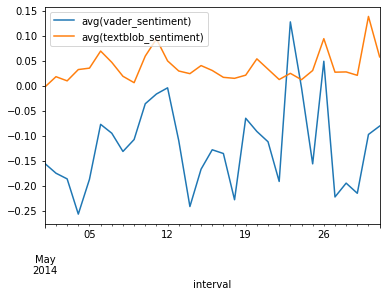

In [ ]:
start_date = "2014-05-01 00:00:00"
end_date = "2014-06-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### June 2014


02
Explosions hit an occupied RSA building in Luhansk city and people get killed.
Ukraine and seperatists deny responsibility, but CNN investigate and concluded that the attack came from the air which points to Ukraine


03
A lot of insurgents killed


11
Ukraine claims Russia allowed tanks to cross the border into Ukraine


13
Ukraine troops regain control in Mariupol


14
Ukrainian air force plane shot down 49 people die


19
Battle of Yampil


20-21
Ukraine Military gains control over Yampil



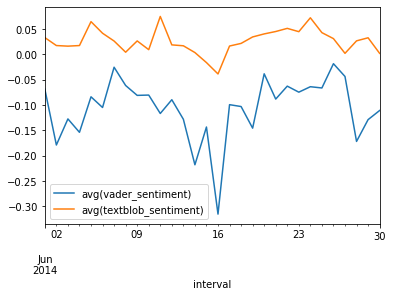

In [ ]:
start_date = "2014-06-01 00:00:00"
end_date = "2014-07-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### July 2014


05
Ukrainian forces recaptures Sloviansk, Kramatorsk


04
Flag of Donetsk People's Republic Raised Over Police Station in Donetsk


13
Shells on the border town of Donetsk in Rostov Oblast, a part of Russia


17
Malaysian Airlines Flight 17 shot down 298 civilians die


21
Heavy fighting in Donetsk



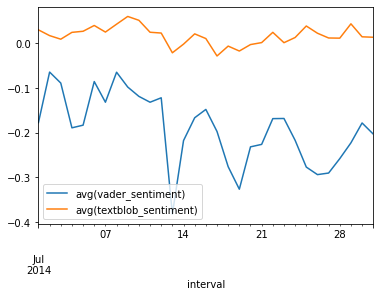

In [ ]:
start_date = "2014-07-01 00:00:00"
end_date = "2014-08-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### August 2014


14
Convoy of some two dozen armored personnel carriers and other vehicles with official Russian military plates crossed into Ukraine


18
A lot of civilians die in Luhansk


20
Ukraine captured significant parts of Luhansk city



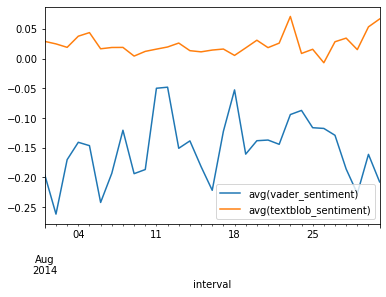

In [ ]:
start_date = "2014-08-01 00:00:00"
end_date = "2014-09-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### September 2014


05
Ceasefire agreed


06-07
Ceasefire broken



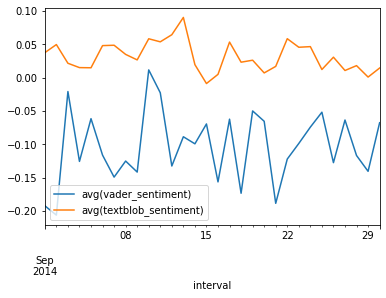

In [ ]:
start_date = "2014-09-01 00:00:00"
end_date = "2014-10-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### November 2014


No date
NATO states it believes Russia is deploying nuclear-capable weapons to Crimea


02
Parliamentary Elections


06
Ukraine lanunches “all out war” against DPR and LPR



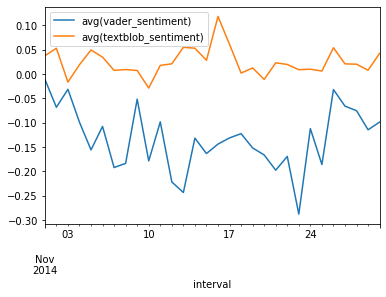

In [ ]:
start_date = "2014-11-01 00:00:00"
end_date = "2014-12-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### December 2014


02
At least 1000 people have died during fighting in the Donbas



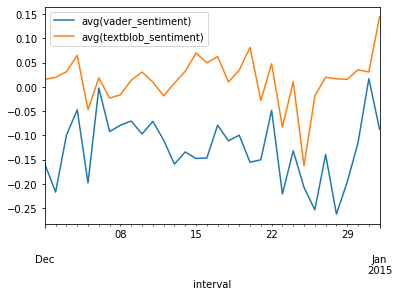

In [ ]:
start_date = "2014-12-01 00:00:00"
end_date = "2015-01-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### January 2015 - Escalation

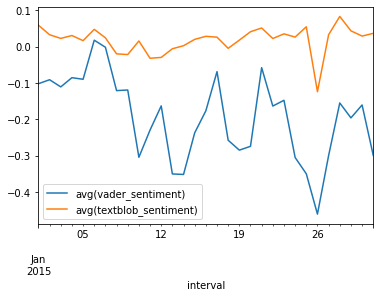

In [ ]:
start_date = "2015-01-01 00:00:00"
end_date = "2015-02-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### February 2016


07
New peace plan by Hollande and Merkel


11
Franco-German peace talks



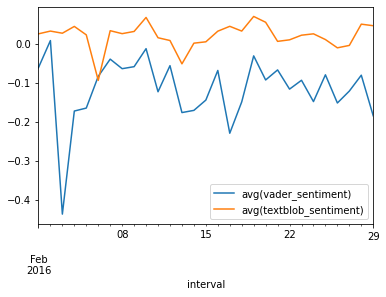

In [ ]:
start_date = "2016-02-01 00:00:00"
end_date = "2016-03-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### January 2017 - Eruption of heavy fighting

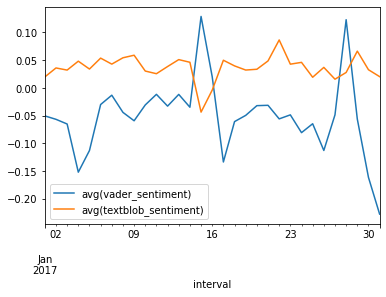

In [ ]:
start_date = "2017-01-01 00:00:00"
end_date = "2017-02-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### October 2019


01
Agreement signed to end conflict (Steinmeier formula)



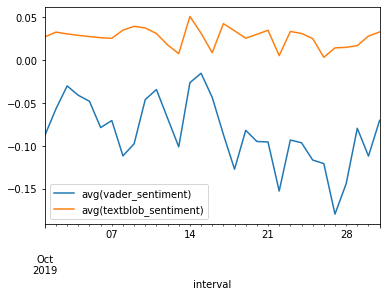

In [ ]:
start_date = "2019-10-01 00:00:00"
end_date = "2019-11-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### June 2020 - Ceasefire

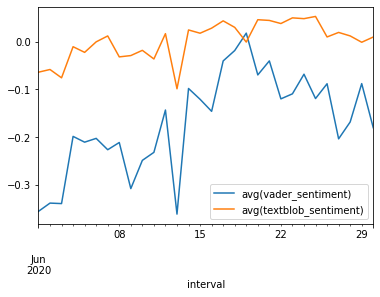

In [ ]:
start_date = "2020-06-01 00:00:00"
end_date = "2020-07-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### September 2020


14
The Ukrainian President Volodymyr Zelenskyy approved Ukraine’s new National Security Strategy which involves partnership with NATO



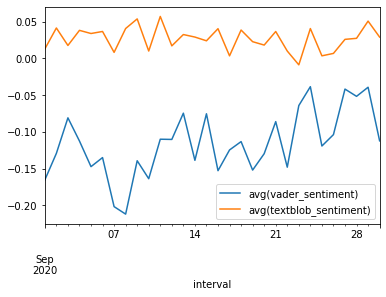

In [ ]:
start_date = "2020-09-01 00:00:00"
end_date = "2020-10-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### December 2021


07
US president Joe Biden warned President of Russia, Vladimir Putin, of “Strong economic and other measures” if Russia Attacks Ukraine

In [ ]:
start_date = "2021-12-01 00:00:00"
end_date = "2022-01-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

KeyboardInterrupt: 

### January 2022


17
Russian troops began arriving in Russia’s ally Belarus, ostensibly for “military exercises”.


19
US gave Ukraine $200 million in security aid
US president Joe Biden stated during a press conference that Russia should be held accountable it it invades.


24
NATO puts troops on standby


25
Russian exercises involving 6000 troops and 60 jets took place in russia near Ukraine and Crimea



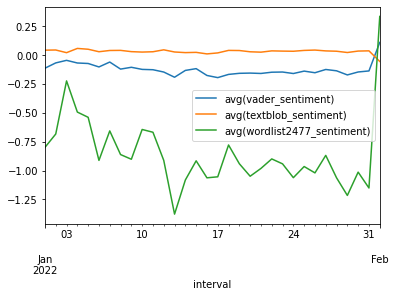

In [ ]:
start_date = "2022-01-01 00:00:00"
end_date = "2022-02-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### February 2022


10
Russia and Belarus began 10 days of military maneuvers


17
Fighting escalated in separatists regions of eastern Ukraine


21
Putin announces that Russia recognizes the independence of two pro-Russian breakaway regions in eastern Ukraine (the Donetsk People’s Republic and the Luhansk People’s republic). This led to the first round of economic sanctions from NATO countries the following day.


24
Putin announces that he made a decision to launch a “special military operation” in eastern Ukraine. 
Within minutes of Putin’s announcement, explosions were reported in Kyiv, Kharkiv, Odessa, and the Donbas.
Ukrainian officials said that Russian troops had landed in Mariupol and Odessa, and had launched missiles at airfields, military headquarters, and military depots. Military vehicles entered Ukraine through Senkivka. Russian troops were also entering Ukraine from Crimea.
Zelenskyy also announced martial law in Ukraine.


25
Bombings continue …
Zelensky accused Russia of targeting civilian sites; Ukrainian Interior Ministry representative Vadym Denysenko said that 33 civilian sites had been hit in the previous 24 hours.
Zelenskyy asks residents to prepare Molov cocktails to “neutralise” the enemy.

Putin meanwhile called on the Ukrainian military to overthrow the government.

Ukraine distributed 18k guns to Kyiv residents who expressed a willingness to fight. He also deployed the Territorial Defence Forces (the reserve component of the Ukrainian military) for the defense of Kyiv.

The Pentagon said that Russian troops were not advancing quickly as either US intelligence or Moscow believed they would. The US also warned that Russia had only sent 30 percent of the 150/190k troops it had massed at the border.


26
More bombings…
The EU bars selected Russian banks from the Society of Worldwide Interbank Financial Telecommunication (SWIFT), cutting them off from the global financial system.


27
The Eu bans Russian civilian aircraft from EU airspace. State-owned media Sputnik and Russia Today (RT), along with their subsidiaries, are banned from EU airwaves and the internet.


28
Ukraine applies to join the EU. Russia and Ukraine start ceasefire talks. The Russian rouble tumbles 30%, forcing Putin to impose capital controls. The EU bans transactions with Russia’s central bank, and approves a 500 million euro support package for the Ukrainian military. It is the first time that the EU has agreed to provide lethal equipment to a third country.



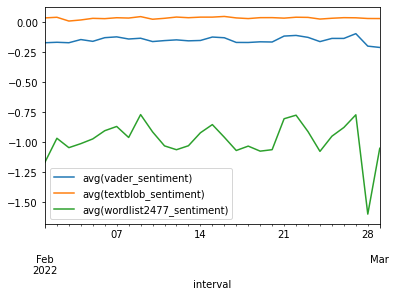

In [ ]:
start_date = "2022-02-01 00:00:00"
end_date = "2022-03-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)

### March 2022


1
A 65km long Russia military convoy heads for Kyiv. Pressure increases on Kharkiv and Mariupol in the east, and Kherson in the south. Human rights Watch reports that Russians are using cluster bombs aganst civilians. The US closes its skies to Russian aircraft.


2
Russian tanks enter Kherson, the first and only regional capital city falling druint the first month of the war. Russian forces surround the port city of Mariupol in southeastern Ukraine. The number of refugees who have fled Ukraine surpasses one million.


3
The International Criminal Court’s top prosecutor sends an advance team to investigate possible war crimes.


4
Putin blocks Twitter, Facebook, and other media platforms in Russia. He signs a law criminalizing “fake news”, which could give offenders up to 15 years in prison.


5
The US urges it citizens to leave Russia immediately

Aeroflot, Russia’s biggest state-owned airline, says it will cease all international flights.


8
US rejects a Polish offre to transfer a fighter aircraft to Ukraine’s airforce, as it seeks to keep NATO out of the war.

The US imposes a ban on Russian crude oil imports, bringing the rise in oil prices since the Russian invasion to 30%.


9
Russian air strikes hit a maternity hospital in Mariupol, kiliing three. Russia says the hospital was housing radicals.
The international monetary fund’s approves $1.4billion in emergency financing for Ukraine.


10
Russian forces bomb an evacuation corridor, preventing humanitarian supplies from reaching Mariupol.


11
Russian kidnap the mayor of Melitopol. Putin approves the deployment of up to 16k irregular fighters from Syria.
The EU issues the Versailles Declaraction, moving in the direction of a European defence capability.


12
Russian forces pillage a humanitarian convoy trying to relieve the city of Mariupol residents


13
Russia roadens its attacks to western Ukraine, firing 30 cruise missiles at a military training base in Yavoriv. At least 35 people are killed and 134 wounded according to Ukrainian officials.


14
Chechen leader and Putin loyalist Ramzan Kadyrov says Chechens have joined Moscow’s fight against Ukraine.

The US warns China it will not tolerate any form of alleviating sanctions against Russia, as US National Security Advisor Jake Sullivan meets China’s Foreign Affairs Director Yang Jiechi for talks.


15
Zelenskyy tells European officials he doesn’t believe NATO membership is a prospect for Ukraine, signalling possible grounds for a compromise in negotiations with Moscow.


16
Russian and Ukrainian negotiators say they are discussing neutrality for Ukraine in return for security guarantees and the departure of Russian troops.





18
Ukraine says it has rescued 130 people from the ruins of Mariupol’s municipal theatre, bombed two days earlier, and warns that hundreds more could be trapped beneath the rubble. A further 5,000 civilians are evacuated from the city, bringing the number of evacuees to 35,000. Russian forces enter the city and fighting is reported in the centre, as Ukrainian officials say the city has lost access to the sea. The Mariupol city council estimates 2,500 people have been killed during the Russian bombardment.

US President Joe Biden warns Chinese President Xi Jinping of “consequences” should China offer Russia “material support” in the conflict.


20
Russian air strikes destroy an art school in Mariupol where some 400 civilians are reportedly sheltering.

The UN says more than 10 million people have been displaced in Ukraine, including those who have fled the country.


21
Ukraine rejects a Russian ultimatum to surrender in Mariupol.


22
Biden says Putin’s constant claims that Ukraine has chemical and biological weapons are a “clear sign he is considering using both of those”.




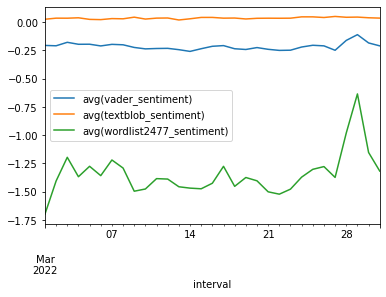

In [ ]:
start_date = "2022-03-01 00:00:00"
end_date = "2022-04-01 00:00:00"

plot_events(df, start_date=start_date, end_date=end_date, combine=COMBINE)